# Guided Revision Conversational Model


This notebook has a model to provide adaptive guided revision through a chatbot that can ask, answer, and personalize revision questions based on the student’s level.

Problem Statement
This notebook has a model to provide adaptive guided revision through a chatbot that can ask, answer, and personalize revision questions based on the student’s level.

# Configuration

In [3]:
#Mount the local drive project_folder
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
!ls "/content/drive/MyDrive/Colab Notebooks (1)/guided_revision_dataset (1).csv"

Mounted at /content/drive/
'/content/drive/MyDrive/Colab Notebooks (1)/guided_revision_dataset (1).csv'


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip -q install -U tensorflow

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

print(tf.__version__)
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
2.19.0
2.19.0


''

# Populating namespaces

In [7]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

#Useful Paths for Data accessibility

In [8]:
# Define the useful paths for data accessibility
dataset_path = '/content/drive/MyDrive/Colab Notebooks (1)/guided_revision_dataset (1).csv'

# Download Dataset

In [9]:
# Assuming the dataset is already in the defined dataset_path on Google Drive
print(f"Dataset path is set to: {dataset_path}")

# Define a flag to control dataset download
download_dataset = True # Set to False if the dataset is already in the Colab environment

if download_dataset:
  try:
    # Copy the dataset from Google Drive to the Colab environment
    !cp "{dataset_path}" /content/
    print("Dataset copied to /content/")
  except Exception as e:
    print(f"Error copying dataset: {e}")
    print("Please ensure the dataset path is correct and Google Drive is mounted.")
else:
  print("Dataset download skipped.")

Dataset path is set to: /content/drive/MyDrive/Colab Notebooks (1)/guided_revision_dataset (1).csv
Dataset copied to /content/


In [10]:
import pandas as pd

# Load the dataset into a pandas DataFrame
df = pd.read_csv(dataset_path)

# Display the first few rows of the DataFrame to verify
display(df.head())

,lesson_id,lesson_topic,subject,level,question,expected_answer,hint,explanation,difficulty,follow_up_question
0,Senior 6_Electricity_3995,Electricity,Physics,Senior 6,Why is Electricity significant for Physics?,Expected answer for Electricity at Senior 6 le...,Try thinking about the key concept of Electric...,This is a detailed explanation about Electrici...,Medium,Give an example of Electricity in real life.
1,Senior 6_Geometry_2603,Geometry,Mathematics,Senior 6,Why is Geometry significant for Mathematics?,Expected answer for Geometry at Senior 6 level...,Try thinking about the key concept of Geometry.,This is a detailed explanation about Geometry ...,Hard,What is the main concept of Geometry?
2,Senior 4_Acids_and_Bases_2879,Acids and Bases,Chemistry,Senior 4,What is the main concept of Acids and Bases?,Expected answer for Acids and Bases at Senior ...,Try thinking about the key concept of Acids an...,This is a detailed explanation about Acids and...,Medium,Why is Acids and Bases significant for Chemistry?
3,Senior 6_Trade_9030,Trade,Economics,Senior 6,Explain the importance of Trade in Economics.,Expected answer for Trade at Senior 6 level in...,Try thinking about the key concept of Trade.,This is a detailed explanation about Trade in ...,Medium,Why is Trade significant for Economics?
4,Senior 5_Trade_3257,Trade,Economics,Senior 5,Describe the key components of Trade.,Expected answer for Trade at Senior 5 level in...,Try thinking about the key concept of Trade.,This is a detailed explanation about Trade in ...,Hard,How does Trade affect Economics?


# Baseline CNN Architecture for Text

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Define levels from the unique values in the 'level' column of the DataFrame
levels = df['level'].unique()
vocab_size = 10000      # Adjust based on your tokenization
embedding_dim = 100     # Embedding size
max_length = 50         # Max length of input sequences
num_classes = len(levels)  # Number of labels

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Data Preprocessing

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Tokenize the text data (questions)
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['question'])
sequences = tokenizer.texts_to_sequences(df['question'])

# Pad the sequences to ensure uniform input length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Encode the labels (levels)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['level'])

print("Original questions sample:", df['question'].head().tolist())
print("Padded sequences shape:", padded_sequences.shape)
print("Original levels sample:", df['level'].head().tolist())
print("Encoded labels sample:", encoded_labels[:5])
print("Encoded labels shape:", encoded_labels.shape)

Original questions sample: ['Why is Electricity significant for Physics?', 'Why is Geometry significant for Mathematics?', 'What is the main concept of Acids and Bases?', 'Explain the importance of Trade in Economics.', 'Describe the key components of Trade.']
Padded sequences shape: (500, 50)
Original levels sample: ['Senior 6', 'Senior 6', 'Senior 4', 'Senior 6', 'Senior 5']
Encoded labels sample: [5 5 3 5 4]
Encoded labels shape: (500,)


# Baseline Training

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences,
    encoded_labels,
    test_size=0.2,  # Using 20% of the data for validation
    random_state=42 # for reproducibility
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (400, 50)
y_train shape: (400,)
X_val shape: (100, 50)
y_val shape: (100,)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,         # Padded token sequences
    y_train,         # Encoded labels (level or topic)
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=10, # You can set a higher number and let EarlyStopping stop it
    callbacks=[early_stopping]
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.1909 - loss: 1.7913 - val_accuracy: 0.1300 - val_loss: 1.8108
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2338 - loss: 1.7627 - val_accuracy: 0.1000 - val_loss: 1.8307
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2101 - loss: 1.7624 - val_accuracy: 0.0800 - val_loss: 1.8312
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2495 - loss: 1.7402 - val_accuracy: 0.1100 - val_loss: 1.8341


### Splitting Data into Training and Validation Sets

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences,
    encoded_labels,
    test_size=0.2,  # Using 20% of the data for validation
    random_state=42 # for reproducibility
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (400, 50)
y_train shape: (400,)
X_val shape: (100, 50)
y_val shape: (100,)


### Model Evaluation

### Hyperparameter Tuning

In [16]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Define the hyperparameters to tune
param_grid = {
    'filters': [64, 128, 256],
    'kernel_size': [3, 5, 7], # Added kernel_size to the grid
    'hidden_dims': [64, 128, 256],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.001, 0.01, 0.0001]
}

best_accuracy = 0
best_params = None
results = []

# Define a value for l2 regularization
l2_lambda = 0.001 # You can tune this as well if needed

# Iterate over each combination of hyperparameters
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")

    # Build the model with the current hyperparameters
    model_tuned = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim), # Removed input_length
        Conv1D(params['filters'], params['kernel_size'], activation='relu', padding='valid'),
        GlobalMaxPooling1D(),
        Dense(params['hidden_dims'], activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(params['dropout_rate']),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model_tuned.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model_tuned.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=32,
        epochs=20, # Increased epochs for tuning, EarlyStopping will prevent overfitting
        callbacks=[early_stopping],
        verbose=0 # Set to 1 to see training progress for each combination
    )

    # Evaluate the model
    loss, accuracy = model_tuned.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Store results
    results.append({'params': params, 'accuracy': accuracy, 'loss': loss})

    # Check if this is the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print("\nBest Parameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

Training with parameters: {'dropout_rate': 0.3, 'filters': 64, 'hidden_dims': 64, 'kernel_size': 3, 'learning_rate': 0.001}
Validation Accuracy: 0.1200
Training with parameters: {'dropout_rate': 0.3, 'filters': 64, 'hidden_dims': 64, 'kernel_size': 3, 'learning_rate': 0.01}
Validation Accuracy: 0.1100
Training with parameters: {'dropout_rate': 0.3, 'filters': 64, 'hidden_dims': 64, 'kernel_size': 3, 'learning_rate': 0.0001}
Validation Accuracy: 0.2000
Training with parameters: {'dropout_rate': 0.3, 'filters': 64, 'hidden_dims': 64, 'kernel_size': 5, 'learning_rate': 0.001}
Validation Accuracy: 0.1100
Training with parameters: {'dropout_rate': 0.3, 'filters': 64, 'hidden_dims': 64, 'kernel_size': 5, 'learning_rate': 0.01}
Validation Accuracy: 0.1000
Training with parameters: {'dropout_rate': 0.3, 'filters': 64, 'hidden_dims': 64, 'kernel_size': 5, 'learning_rate': 0.0001}
Validation Accuracy: 0.1800
Training with parameters: {'dropout_rate': 0.3, 'filters': 64, 'hidden_dims': 64, 'kerne

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Loss: 1.8183
Validation Accuracy: 0.0800


### Visualize Training History

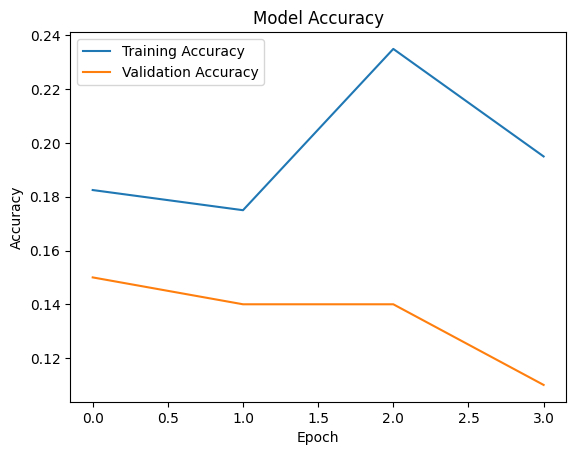

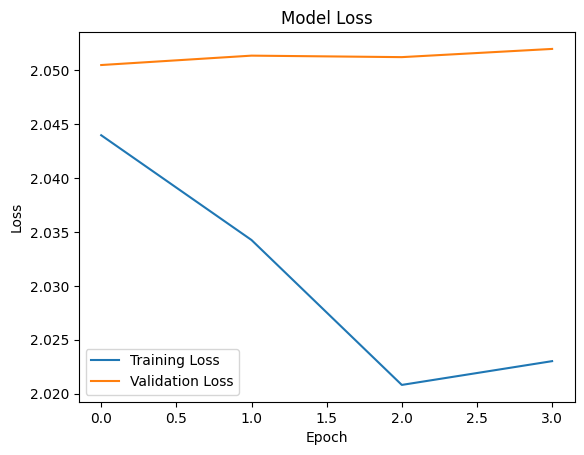

In [17]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Advanced CNN Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D

# Define an advanced CNN architecture
model_advanced_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='valid'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='valid'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_advanced_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_advanced_cnn.summary()

Model: "sequential_244"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_244 (Embedding)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_244 (Conv1D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_245 (Conv1D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_244        │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_488 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_244 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_489 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Define the hyperparameters to tune for the advanced CNN
param_grid_advanced = {
    'conv1d_1_filters': [64, 128, 256],
    'conv1d_1_kernel_size': [3, 5, 7],
    'conv1d_2_filters': [128, 256, 512],
    'conv1d_2_kernel_size': [3, 5],
    'dense_hidden_dims': [64, 128, 256],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.001, 0.01, 0.0001]
}

best_accuracy_advanced = 0
best_params_advanced = None
results_advanced = []

# Define a value for l2 regularization
l2_lambda_advanced = 0.001

# Iterate over each combination of hyperparameters
for params in ParameterGrid(param_grid_advanced):
    print(f"Training with parameters: {params}")

    # Build the advanced model with the current hyperparameters
    model_tuned_advanced = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        Conv1D(params['conv1d_1_filters'], params['conv1d_1_kernel_size'], activation='relu', padding='valid'),
        MaxPooling1D(pool_size=2),
        Conv1D(params['conv1d_2_filters'], params['conv1d_2_kernel_size'], activation='relu', padding='valid'),
        GlobalMaxPooling1D(),
        Dense(params['dense_hidden_dims'], activation='relu', kernel_regularizer=l2(l2_lambda_advanced)),
        Dropout(params['dropout_rate']),
        Dense(num_classes, activation='softmax')
    ])

    optimizer_advanced = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model_tuned_advanced.compile(optimizer=optimizer_advanced, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping_advanced = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history_advanced = model_tuned_advanced.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=32,
        epochs=20,
        callbacks=[early_stopping_advanced],
        verbose=0
    )

    # Evaluate the model
    loss_advanced, accuracy_advanced = model_tuned_advanced.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {accuracy_advanced:.4f}")

    # Store results
    results_advanced.append({'params': params, 'accuracy': accuracy_advanced, 'loss': loss_advanced})

    # Check if this is the best model
    if accuracy_advanced > best_accuracy_advanced:
        best_accuracy_advanced = accuracy_advanced
        best_params_advanced = params

print("\nBest Parameters (Advanced CNN):", best_params_advanced)
print("Best Validation Accuracy (Advanced CNN):", best_accuracy_advanced)

Training with parameters: {'conv1d_1_filters': 64, 'conv1d_1_kernel_size': 3, 'conv1d_2_filters': 128, 'conv1d_2_kernel_size': 3, 'dense_hidden_dims': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001}
Validation Accuracy: 0.1700
Training with parameters: {'conv1d_1_filters': 64, 'conv1d_1_kernel_size': 3, 'conv1d_2_filters': 128, 'conv1d_2_kernel_size': 3, 'dense_hidden_dims': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01}
Validation Accuracy: 0.1200
Training with parameters: {'conv1d_1_filters': 64, 'conv1d_1_kernel_size': 3, 'conv1d_2_filters': 128, 'conv1d_2_kernel_size': 3, 'dense_hidden_dims': 64, 'dropout_rate': 0.3, 'learning_rate': 0.0001}
Validation Accuracy: 0.2300
Training with parameters: {'conv1d_1_filters': 64, 'conv1d_1_kernel_size': 3, 'conv1d_2_filters': 128, 'conv1d_2_kernel_size': 3, 'dense_hidden_dims': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001}
Validation Accuracy: 0.1000
Training with parameters: {'conv1d_1_filters': 64, 'conv1d_1_kernel_size': 3, 'conv1d_2_

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

# Assuming 'history_advanced' from the last hyperparameter tuning run
# contains the training history for the best advanced CNN model.
# If you ran the tuning with verbose=0, you might need to re-train
# the best model separately with verbose=1 to get the history object.

# Plot training and validation accuracy for the best advanced CNN
if 'history_advanced' in locals():
    plt.plot(history_advanced.history['accuracy'], label='Training Accuracy')
    plt.plot(history_advanced.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Advanced CNN Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot training and validation loss for the best advanced CNN
    plt.plot(history_advanced.history['loss'], label='Training Loss')
    plt.plot(history_advanced.history['val_loss'], label='Validation Loss')
    plt.title('Advanced CNN Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
else:
    # Re-run the best advanced CNN training with verbose=1 to get history
    print("Re-training best advanced CNN model to get history...")
    # Assuming best_params_advanced and model_tuned_advanced from previous tuning
    if 'best_params_advanced' in locals():
        model_tuned_advanced = Sequential([
            Embedding(input_dim=vocab_size, output_dim=embedding_dim),
            Conv1D(best_params_advanced['conv1d_1_filters'], best_params_advanced['conv1d_1_kernel_size'], activation='relu', padding='valid'),
            MaxPooling1D(pool_size=2),
            Conv1D(best_params_advanced['conv1d_2_filters'], best_params_advanced['conv1d_2_kernel_size'], activation='relu', padding='valid'),
            GlobalMaxPooling1D(),
            Dense(best_params_advanced['dense_hidden_dims'], activation='relu', kernel_regularizer=l2(l2_lambda_advanced)),
            Dropout(best_params_advanced['dropout_rate']),
            Dense(num_classes, activation='softmax')
        ])

        optimizer_advanced = tf.keras.optimizers.Adam(learning_rate=best_params_advanced['learning_rate'])
        model_tuned_advanced.compile(optimizer=optimizer_advanced, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        early_stopping_advanced = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        history_advanced = model_tuned_advanced.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            batch_size=32,
            epochs=20,
            callbacks=[early_stopping_advanced],
            verbose=1 # Set to 1 to see training progress
        )

        plt.plot(history_advanced.history['accuracy'], label='Training Accuracy')
        plt.plot(history_advanced.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Advanced CNN Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

        plt.plot(history_advanced.history['loss'], label='Training Loss')
        plt.plot(history_advanced.history['val_loss'], label='Validation Loss')
        plt.title('Advanced CNN Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

    else:
        print("Best tuned advanced CNN model parameters not found.")


# Generate Confusion Matrix for the best performing advanced CNN model
# Assuming 'model_tuned_advanced' from the last tuning run is the best model.
# If not, you might need to rebuild and train the best model separately.
if 'model_tuned_advanced' in locals():
    y_pred_advanced = model_tuned_advanced.predict(X_val)
    y_pred_classes_advanced = np.argmax(y_pred_advanced, axis=1)

    cm_advanced = confusion_matrix(y_val, y_pred_classes_advanced)
    disp_advanced = ConfusionMatrixDisplay(confusion_matrix=cm_advanced, display_labels=label_encoder.classes_)
    disp_advanced.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Advanced CNN)')
    plt.show()
else:
    print("Best tuned advanced CNN model not found. Please ensure 'model_tuned_advanced' is available after re-training.")


# Create Comparison Table
# Assuming 'results' and 'results_advanced' contain the tuning results
if 'results' in locals() and 'results_advanced' in locals():
    # Find the best results from both tuning processes
    best_baseline_result = max(results, key=lambda x: x['accuracy'])
    best_advanced_result = max(results_advanced, key=lambda x: x['accuracy'])

    # Include the initial baseline model performance as well
    # Assuming 'accuracy' and 'loss' variables from the initial baseline training
    initial_baseline_performance = {'Model': 'Baseline CNN (Initial)', 'Accuracy': accuracy, 'Loss': loss}

    comparison_data = [
        initial_baseline_performance,
        {'Model': 'Baseline CNN (Tuned)', 'Accuracy': best_baseline_result['accuracy'], 'Loss': best_baseline_result['loss']},
        {'Model': 'Advanced CNN (Tuned)', 'Accuracy': best_advanced_result['accuracy'], 'Loss': best_advanced_result['loss']}
    ]

    comparison_df = pd.DataFrame(comparison_data)
    print("\nModel Comparison Table:")
    display(comparison_df)
else:
    print("Tuning results not found. Please ensure 'results' and 'results_advanced' are available.")

Re-training best advanced CNN model to get history...
Best tuned advanced CNN model parameters not found.
Best tuned advanced CNN model not found. Please ensure 'model_tuned_advanced' is available after re-training.
Tuning results not found. Please ensure 'results' and 'results_advanced' are available.
